In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import sys, os
import datetime
%load_ext autoreload
%autoreload 2

# data path, constants, etc.
import sys
datapath = '/Users/nhamilto/Documents/ATom/data/20180913_mictest/'
sys.path.append(datapath)

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# Acoustic tomography functions
import ATom.atom_functions as atom

In [2]:
oldfileindex = pd.read_csv(datapath+'old_mic_file_index_20181209.txt', delim_whitespace=True, skiprows=3)
newfileindex = pd.read_csv(datapath+'new_mic_file_index_20181209.txt', delim_whitespace=True, skiprows=3)

### load atom dataset object for meta data

In [3]:
adat = atom.dataset('/Users/nhamilto/Documents/ATom/data/20180913_Data_collection/')

In [131]:
# column names in each data file
cols = ['S{}'.format(x) for x in range(8)] + ['M{}'.format(x) for x in range(8)]
# instantiate characterization data structure
chardata = pd.DataFrame()

# read in data from Mic 1
for ii in range(len(oldfileindex)):
    timestamp = oldfileindex['Filename/Timestamp'].iloc[ii].split('_')[0]
    fload = datapath + timestamp + '_AcouTomMainData' + '.txt'
    testdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['M0'])
    chardata[str(oldfileindex['OffsetAngle'].iloc[ii])] = testdat['M0'].values
    # grab some speaker data as well. It should be identical for every record, so only get one.
    if ii==0:
        speakerdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['S0'])
        speakerdat.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(speakerdat.index)), inplace=True)
        
# set index to be time delta from the beginning of each recording
chardata.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(chardata.index)), inplace=True)

In [132]:
old_mic_data = chardata.copy()

In [5]:
# calculate the number of frames within the file
nframe = int(len(speakerdat) / 10000)
frameindex = [
    speakerdat.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
speakerdat['frame'] = frameseries
speakerdat['frame'].ffill(inplace=True)

# reindex by both the frame number and the time index
speakerdat.set_index(['frame', speakerdat.index], inplace=True)

In [6]:
# calculate the number of frames within the file
nframe = int(len(chardata) / 10000)
frameindex = [
    chardata.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
chardata['frame'] = frameseries
chardata['frame'].ffill(inplace=True)

# reindex by both the frame number and the time index
chardata.set_index(['frame', chardata.index], inplace=True)

### extract a single speaker chirp

In [7]:
# single frame
speakersamp = speakerdat.xs('frame 0', level=0)
# constant parameters
chirp_record_length = adat.meta.chirp_record_length # samples within the chirp
upsamplefactor = 10
samplefreq = adat.meta.main_sampling_freq
searchLag = 3 * chirp_record_length * upsamplefactor
# upsample 
speakersamp = atom.upsample(speakersamp, upsamplefactor)
speakerstartindex = np.array([np.squeeze(speakersamp.values.round(5)).nonzero()[0][0]]) # atom.get_speaker_signal_delay(speakersamp) 

speakersigs = atom.signalOnSpeaker(speakersamp, searchLag, chirp_record_length*upsamplefactor, speakerstartindex)


### Extract mic signals



In [8]:
# load aux data to get speed of sound
timestamp = oldfileindex['Filename/Timestamp'].iloc[0].split('_')[0]
fload = datapath + timestamp + '_AcouTomAuxData' + '.txt'
cols = ['vx','vy','vz','c','T','H']
auxdat = pd.read_csv(fload, skiprows=4, names=cols, delim_whitespace=True, usecols=['c'])
c0 = auxdat.values.mean()
signalETAs = np.array([2 / c0])

etaindex = (signalETAs * samplefreq * upsamplefactor).round() + speakerstartindex 
etaindex = etaindex[:].repeat(len(chardata.columns))

In [9]:
tr = np.zeros((len(chardata.columns), nframe))
alpha = tr.copy()
sortedcols = [str(int(x*10)) for x in range(-10,11)]

for fi in range(nframe):
    micsamp = chardata.xs('frame {}'.format(fi), level=0)
    micsamp = atom.freq_filter(micsamp, adat.meta.filter_freq_inds)
    micsamp = atom.upsample(micsamp, upsamplefactor)

    micsamp = micsamp.reindex(sortedcols, axis=1)
    start = int(etaindex[0] - (searchLag)/2)
    for ic, col in enumerate(micsamp.columns):
        temp = micsamp[col].iloc[start:start + searchLag]
        covar = np.correlate(temp, np.squeeze(speakersigs.values), mode='same')
        alpha[ic,fi] = int(col) 
        tr[ic,fi] = np.argmax(covar) - searchLag/2

tr = tr.astype(int)

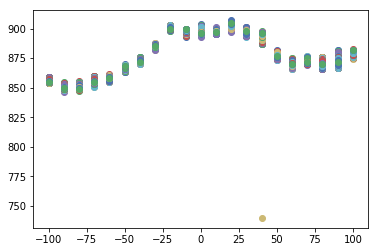

In [10]:
scat = plt.plot(alpha, tr, 'o')

In [12]:
today = datetime.date.today().strftime('%Y%m%d')
savefile = os.path.join(datapath,today+'_oldmicdata.csv')
np.savetxt(savefile, tr.T)

# Data from new microphone

In [133]:
# column names in each data file
cols = ['S{}'.format(x) for x in range(8)] + ['M{}'.format(x) for x in range(8)]
# instantiate characterization data structure
chardata = pd.DataFrame()
catdat = pd.DataFrame()

# read in data from Mic 1
for ii in range(len(newfileindex)):
    timestamp = newfileindex['Filename/Timestamp'].iloc[ii].split('_')[0]
    fload = datapath + timestamp + '_AcouTomMainData' + '.txt'
    testdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['M0'])
    newcol = str(newfileindex['OffsetAngle'].iloc[ii]) + '_' + str(ii%3)
    catdat = pd.concat([catdat, testdat.iloc[0:1200000]], ignore_index=True, axis=0) 
    if ii%3 == 2:
        if ii==2:
            chardata = catdat
        chardata[str(newfileindex['OffsetAngle'].iloc[ii])] = catdat
        del catdat
        catdat = pd.DataFrame()
    # grab some speaker data as well. It should be identical for every record, so only get one.
    if ii==0:
        speakerdat = pd.read_csv(fload, skiprows=4, delim_whitespace=True, names=cols, usecols=['S0'])
        speakerdat.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(speakerdat.index)), inplace=True)
        
# set index to be time delta from the beginning of each recording
chardata.drop('M0', axis=1, inplace=True)
chardata.set_index(pd.TimedeltaIndex(freq='50U', start=0, periods=len(chardata.index)), inplace=True)

In [134]:
new_mic_data = chardata.copy()

In [14]:
# calculate the number of frames within the file
nframe = int(len(chardata) / 10000)
frameindex = [
    chardata.index[0] + ii * pd.Timedelta(value=0.5, unit='s')
    for ii in range(nframe)
]
# add frame number as a series
framedata = ['frame {}'.format(ii) for ii in range(nframe)]
frameseries = pd.Series(data=framedata, index=frameindex)
chardata['frame'] = frameseries
chardata['frame'].ffill(inplace=True)

# reindex by both the frame number and the time index
chardata.set_index(['frame', chardata.index], inplace=True)

framelength = len(chardata.xs('frame 0', level=0))

In [15]:
# single frame
speakersamp = speakerdat.iloc[0:framelength]
# constant parameters
chirp_record_length = adat.meta.chirp_record_length # samples within the chirp
upsamplefactor = 10
samplefreq = adat.meta.main_sampling_freq
searchLag = 3 * chirp_record_length * upsamplefactor
# upsample 
speakersamp = atom.upsample(speakersamp, upsamplefactor)
speakerstartindex = np.array([np.squeeze(speakersamp.values.round(5)).nonzero()[0][0]]) # atom.get_speaker_signal_delay(speakersamp) 

speakersigs = atom.signalOnSpeaker(speakersamp, searchLag, chirp_record_length*upsamplefactor, speakerstartindex)


In [16]:
# load aux data to get speed of sound
timestamp = oldfileindex['Filename/Timestamp'].iloc[0].split('_')[0]
fload = datapath + timestamp + '_AcouTomAuxData' + '.txt'
cols = ['vx','vy','vz','c','T','H']
auxdat = pd.read_csv(fload, skiprows=4, names=cols, delim_whitespace=True, usecols=['c'])
c0 = auxdat.values.mean()
signalETAs = np.array([2 / c0])

etaindex = (signalETAs * samplefreq * upsamplefactor).round() + speakerstartindex 
etaindex = etaindex[:].repeat(len(micsamp.columns))

In [17]:
tr = np.zeros((len(micsamp.columns), nframe))
alpha = tr.copy()
sortedcols = [str(int(x*10)) for x in range(-10,11)]

for fi in range(nframe):
    micsamp = chardata.xs('frame {}'.format(fi), level=0)
    micsamp = atom.freq_filter(micsamp, adat.meta.filter_freq_inds)
    micsamp = atom.upsample(micsamp, upsamplefactor)

    micsamp = micsamp.reindex(sortedcols, axis=1)
    start = int(etaindex[0] - (searchLag)/2)
    for ic, col in enumerate(micsamp.columns):
        temp = micsamp[col].iloc[start:start + searchLag]
        covar = np.correlate(temp, np.squeeze(speakersigs.values), mode='same')
        alpha[ic,fi] = int(col) 
        tr[ic,fi] = np.argmax(covar) - searchLag/2

tr = tr.astype(int)

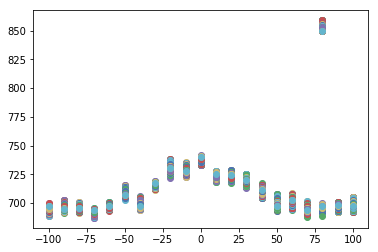

In [18]:
scat = plt.plot(alpha, tr, 'o')

In [18]:
today = datetime.date.today().strftime('%Y%m%d')
savefile = os.path.join(datapath,today+'_newmicdata.csv')
np.savetxt(savefile, tr.T)

In [19]:
newdat = pd.DataFrame(data = tr.T, columns=[str(x) for x in alpha[:,0]])

In [20]:
newdat.describe()

,-100.0,-90.0,-80.0,-70.0,-60.0,-50.0,-40.0,-30.0,-20.0,-10.0,...,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,...,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,694.455556,697.902778,696.725000,691.919444,696.983333,710.844444,700.505556,715.136111,729.683333,728.344444,...,723.722222,723.702778,719.497222,708.888889,700.394444,699.919444,695.352778,848.177778,696.500000,697.269444
std,2.076053,2.329176,1.795828,1.681179,1.266562,2.879806,2.541022,1.506098,2.335329,2.489694,...,1.805456,2.132908,2.596332,2.628087,2.528935,3.142247,2.353328,28.524369,1.981811,3.045095
min,689.000000,691.000000,691.000000,687.000000,693.000000,703.000000,694.000000,711.000000,722.000000,723.000000,...,718.000000,717.000000,713.000000,704.000000,693.000000,694.000000,688.000000,689.000000,692.000000,692.000000
25%,693.000000,696.000000,696.000000,691.000000,696.000000,709.000000,699.000000,714.000000,728.000000,726.000000,...,723.000000,722.000000,717.000000,707.000000,699.000000,698.000000,694.000000,852.000000,695.000000,695.000000
50%,695.000000,698.000000,697.000000,692.000000,697.000000,711.000000,700.000000,715.000000,729.500000,728.000000,...,724.000000,724.000000,720.000000,709.000000,700.000000,699.000000,695.000000,853.000000,697.000000,697.000000
75%,696.000000,699.250000,698.000000,693.000000,698.000000,713.000000,703.000000,716.000000,731.000000,730.000000,...,725.000000,725.000000,721.000000,710.000000,702.000000,702.000000,697.000000,855.000000,698.000000,699.000000
max,700.000000,703.000000,701.000000,696.000000,701.000000,716.000000,706.000000,719.000000,738.000000,736.000000,...,728.000000,729.000000,725.000000,717.000000,708.000000,709.000000,702.000000,859.000000,701.000000,705.000000


In [23]:
olddat = pd.read_csv(os.path.join(datapath,today+'_oldmicdata.csv'), delim_whitespace=True, names=[str(x) for x in alpha[:,0]])

In [24]:
olddat.shape

(122, 21)

In [25]:
olddat.describe()

,-100.0,-90.0,-80.0,-70.0,-60.0,-50.0,-40.0,-30.0,-20.0,-10.0,...,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,100.0
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,...,122.000000,122.000000,122.00000,122.00000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,856.844262,850.631148,851.778689,856.000000,858.729508,866.565574,873.319672,885.131148,901.245902,896.918033,...,897.245902,901.270492,896.97541,890.02459,876.614754,870.729508,873.040984,870.516393,872.532787,878.204918
std,1.515869,1.306062,1.741626,2.143605,1.426067,1.605711,1.374300,1.232821,1.173477,1.751458,...,1.201318,1.876505,1.81574,13.93756,1.778878,1.863246,1.783290,2.697515,3.382464,1.884862
min,854.000000,846.000000,847.000000,851.000000,855.000000,863.000000,870.000000,882.000000,898.000000,893.000000,...,895.000000,897.000000,893.00000,740.00000,873.000000,866.000000,869.000000,866.000000,867.000000,874.000000
25%,855.000000,850.000000,851.000000,854.000000,858.000000,865.250000,873.000000,884.000000,901.000000,896.000000,...,897.000000,900.000000,895.00000,889.00000,875.000000,870.000000,872.000000,868.250000,870.000000,877.000000
50%,857.000000,850.000000,852.000000,856.000000,859.000000,867.000000,873.000000,885.000000,901.000000,897.000000,...,897.000000,901.000000,897.00000,891.00000,877.000000,871.000000,873.000000,870.000000,872.000000,878.000000
75%,858.000000,851.000000,853.000000,858.000000,859.000000,868.000000,874.000000,886.000000,902.000000,898.000000,...,898.000000,903.000000,898.00000,893.00000,878.000000,872.000000,874.000000,873.000000,875.000000,879.000000
max,859.000000,855.000000,856.000000,860.000000,862.000000,870.000000,876.000000,888.000000,903.000000,900.000000,...,901.000000,907.000000,901.00000,898.00000,882.000000,875.000000,877.000000,876.000000,882.000000,883.000000


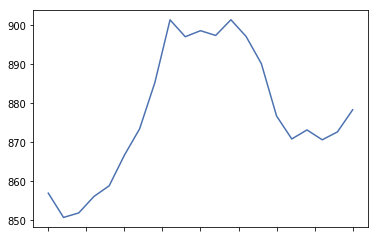

In [27]:
olddat.mean().plot()

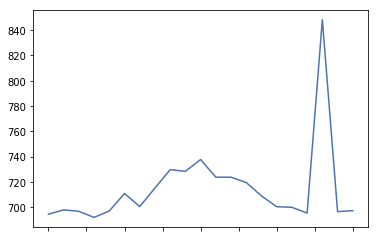

In [28]:
newdat.mean().plot()

Text(0,0.5,'Time delay [ms]')

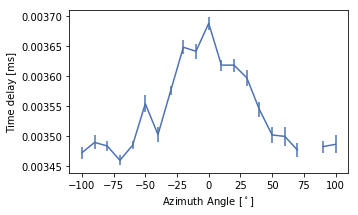

In [97]:
test = newdat.copy()
test['80.0'] = np.NaN
tstats = test.describe().T
# tstats['mean'].plot(yerr=tstats['std'])

fig, ax = plt.subplots(figsize=(5,3))
ax.errorbar(np.array([x*10 for x in range(-10,11)]), tstats['mean'].values/(samplefreq*upsamplefactor), yerr=tstats['std']/(samplefreq*upsamplefactor))
ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Time delay [ms]')

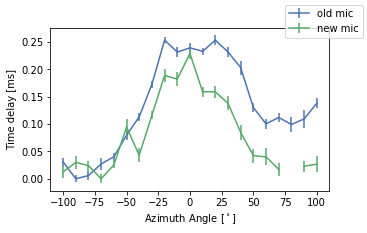

In [110]:
newstats = newdat.copy()
newstats['80.0'] = np.NaN
newstats = newstats.describe().T
newstats['mean'] -= newstats['mean'].min()

oldstats = olddat.copy()
mask = (oldstats < oldstats.quantile(q=0.01))
oldstats[mask] = np.NaN
oldstats = oldstats.describe().T
oldstats['mean'] -= oldstats['mean'].min()

fig, ax = plt.subplots(figsize=(5,3))
ax.errorbar(np.array([x*10 for x in range(-10,11)]), oldstats['mean'].values/(samplefreq*upsamplefactor/1000), yerr=oldstats['std']/(samplefreq*upsamplefactor/1000))

ax.errorbar(np.array([x*10 for x in range(-10,11)]), newstats['mean'].values/(samplefreq*upsamplefactor/1000), yerr=newstats['std']/(samplefreq*upsamplefactor/1000))
ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Time delay [ms]')

fig.legend(['old mic','new mic'])

In [102]:
from scipy import optimize

def cosine_fit_func(x, a, b, c):
    return a * np.cos(b * x)+c

### Speaker characterization data
signal latency at several fixed radial distances from the center of the speaker aperature as a function of azimuth angle

In [103]:
colnames = ['azangle'] + [x for x in range(120)]
speaker = pd.read_csv('../../data/speaker_char_raw_data_210818.csv', names=colnames, skiprows=1)

speaker['azangle'].ffill(inplace=True)
speaker = speaker.set_index('azangle').drop('4m', axis=0)
speaker.set_index(pd.to_numeric(speaker.index), inplace=True)
speaker['radius'] = np.concatenate(((2*np.ones(int(len(speaker.index)/2))).astype(int), (4*np.ones(int(len(speaker.index)/2+1))).astype(int)))
speaker.reset_index(inplace=True)
speaker.set_index(['radius','azangle'], inplace=True)


- calculate mean offset time,
- exclude outliers,
- separate by radial distance, 
- subtract minimum value, 

In [128]:
# get mean values over 120 records
meanoff = speaker.T.mean()

# remove and replace obvious outliers
meanoff.loc[2,[-40,40]] = np.nan
meanoff.interpolate(inplace=True)
meanoff.loc[4,[-100]] = np.nan
meanoff.bfill(inplace=True)

# extract data for radial distance = 2 m
rad2 = meanoff.xs(2, level=0) - meanoff.xs(2, level=0).min()
rad2 = rad2.reset_index()
rad2.columns = ['azangle', 'offset']

# extract data for radial distance = 4 m
rad4 = meanoff.xs(4, level=0) - meanoff.xs(4, level=0).min()
rad4 = rad4.reset_index()
rad4.columns = ['azangle', 'offset']

# fit cosine curve to data
rad2params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad2['azangle']), rad2['offset'], p0=[0.15, 2, 0.15])
rad4params, params_covariance = optimize.curve_fit(cosine_fit_func, np.radians(rad4['azangle']), rad4['offset'], p0=[0.15, 2, 0.15])

rad2fit = cosine_fit_func(np.radians(rad2['azangle']), rad2params[0], rad2params[1], rad2params[2])
rad4fit = cosine_fit_func(np.radians(rad4['azangle']), rad4params[0], rad4params[1], rad4params[2])

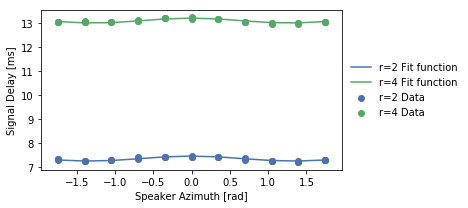

In [125]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(np.radians(rad2['azangle']), rad2['offset'], label='r=2 Data')
ax.plot(np.radians(rad2['azangle']), rad2fit,
         label='r=2 Fit function')

ax.scatter(np.radians(rad4['azangle']), rad4['offset'], label='r=4 Data', color='C1')
ax.plot(np.radians(rad4['azangle']), rad4fit,
         label='r=4 Fit function', color='C1')

ax.legend(loc=6, bbox_to_anchor=(1,0.5), frameon=False)

ax.set_xlabel('Speaker Azimuth [rad]')
ax.set_ylabel('Signal Delay [ms]')

fig.tight_layout()
fig.savefig('../figures/speaker_char_time_offsets.png', dpi=200, bbox_inches='tight')

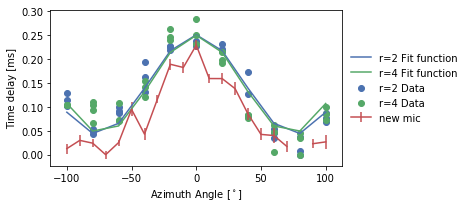

In [130]:
newstats = newdat.copy()
newstats['80.0'] = np.NaN
newstats = newstats.describe().T
newstats['mean'] -= newstats['mean'].min()

oldstats = olddat.copy()
mask = (oldstats < oldstats.quantile(q=0.01))
oldstats[mask] = np.NaN
oldstats = oldstats.describe().T
# oldstats['mean'] -= oldstats['mean'].min()

fig, ax = plt.subplots(figsize=(5,3))
# ax.errorbar(np.array([x*10 for x in range(-10,11)]), 
#             oldstats['mean'].values/(samplefreq*upsamplefactor/1000), 
#             yerr=oldstats['std']/(samplefreq*upsamplefactor/1000),
#            label='old mic, new data')

ax.errorbar(np.array([x*10 for x in range(-10,11)]), 
            newstats['mean'].values/(samplefreq*upsamplefactor/1000), 
            yerr=newstats['std']/(samplefreq*upsamplefactor/1000),
            label='new mic', color='C2')

ax.scatter(rad2['azangle'], rad2['offset'], label='r=2 Data')
ax.plot(rad2['azangle'], rad2fit,
         label='r=2 Fit function')

ax.scatter(rad4['azangle'], rad4['offset'], label='r=4 Data', color='C1')
ax.plot(rad4['azangle'], rad4fit,
         label='r=4 Fit function', color='C1')

ax.legend(loc=6, bbox_to_anchor=(1,0.5), frameon=False)

ax.set_xlabel('Azimuth Angle [$^\circ$]')
ax.set_ylabel('Time delay [ms]')

fig.tight_layout()
fig.savefig('../figures/new_mic_test.png', dpi=200, bbox_inches='tight')

In [135]:
old_mic_data.shape

(1220000, 21)

In [136]:
new_mic_data.shape

(3600000, 21)

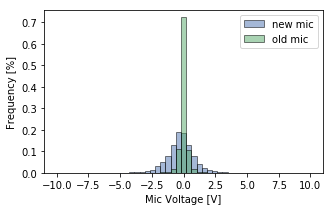

In [196]:
fig,ax = plt.subplots(figsize=(5,3))

ax.hist(new_mic_data['0'], bins = np.linspace(-10,10,50), 
        weights=np.ones(len(new_mic_data['0']))/len(new_mic_data['0']), 
        edgecolor='k', alpha=0.5)
ax.hist(old_mic_data['0'], bins = np.linspace(-10,10,50), 
        weights=np.ones(len(old_mic_data['0']))/len(old_mic_data['0']), 
        edgecolor='k', alpha=0.5)

ax.set_xlabel('Mic Voltage [V]')
ax.set_ylabel('Frequency [%]')

ax.legend(['new mic','old mic'])
fig.savefig('../figures/mic_hist.png', dpi=200, bbox_inches='tight')

In [181]:
new0 = np.abs(np.fft.fft(new_mic_data['0'].values))**2
newfreqs = np.fft.fftfreq(len(new_mic_data['0'].values), d=1/20000)

old0 = np.abs(np.fft.fft(old_mic_data['0'].values))**2
oldfreqs = np.fft.fftfreq(len(old_mic_data['0'].values), d=1/20000)


In [ ]:
adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2

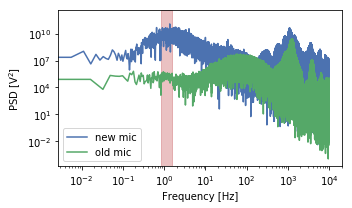

In [197]:
fig=plt.figure(figsize=(5,3))

plt.plot(newfreqs[0:int(len(new0)/2)], new0[0:int(len(new0)/2)], label='new mic')
plt.plot(oldfreqs[0:int(len(old0)/2)], old0[0:int(len(old0)/2)], label='old mic')

plt.yscale('log')
plt.xscale('log')

plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V$^2$]')

plt.axvspan(adat.meta.chirp_freq-adat.meta.chirp_bandWidth/2, adat.meta.chirp_freq+adat.meta.chirp_bandWidth/2, color='C2', alpha=0.35)

plt.legend()

fig.tight_layout()
fig.savefig('../figures/mic_psd.png', dpi=200, bbox_inches='tight')

/Users/nhamilto/.local/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/nhamilto/.local/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


(<matplotlib.figure.Figure at 0x121c84390>,)

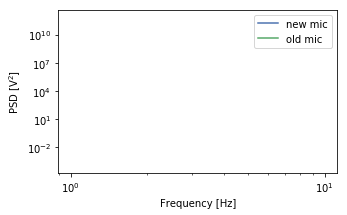

In [189]:
fig,ax = plt.subplots(figsize=(5,3))
start = int(len(newfreqs)/2)
ax.plot(newfreqs[start:], newFFT[start:])
start = int(len(oldfreqs)/2)

ax.plot(oldfreqs[start:], oldFFT[start:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [V$^2$]')

ax.legend(['new mic','old mic'])
fig,

In [167]:
adat.meta.chirp_freq

1.2